<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/MLP_Validation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

import helper

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 10)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.layer1(x)))
        x = self.dropout(F.relu(self.layer2(x)))
        x = self.dropout(F.relu(self.layer3(x)))
        x = self.dropout(F.relu(self.layer4(x)))

        # output so no dropout here
        x = F.log_softmax(self.layer5(x), dim=1)

        return x

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

#data set
train_data = datasets.mnist.FashionMNIST(root="data/Fashion",train=True,download=True,transform=transform)
test_data = datasets.mnist.FashionMNIST(root="data/Fashion",train=False,download=True,transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
print(num_train)

Processing...
Done!
60000


In [0]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# Index of num train
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
# Data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

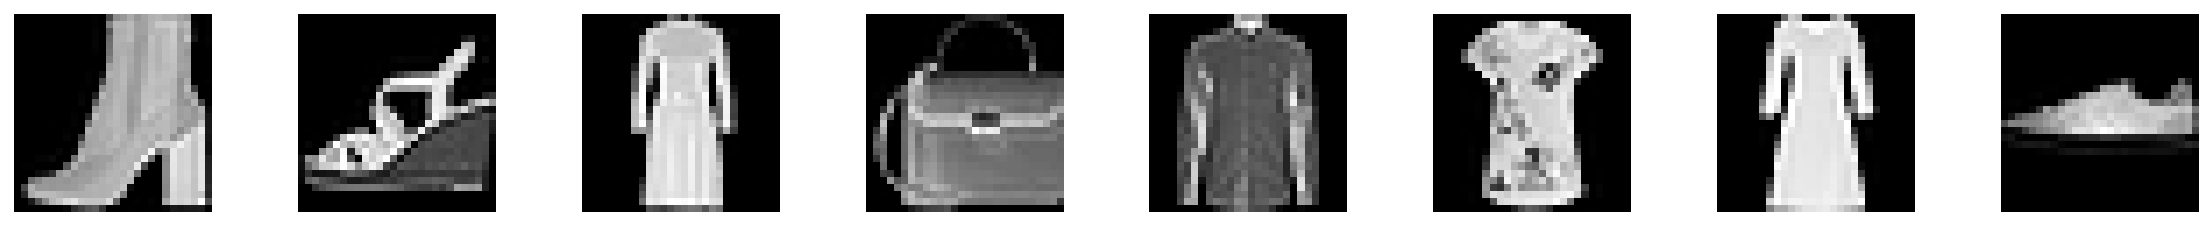

In [17]:
# Visualize data

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    # ax.set_title(str(labels[idx].item()))


In [19]:
model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.003)

# Gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#move tensor to default device
model.to(device)

Network(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [0]:
# Train model
epoch = 5


# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for e in range(epoch):
  # monitor training loss
  train_loss = 0.0
  valid_loss = 0.0
  
  # train model
  model.train()
  
  for images,labels in train_loader:
    # Move input and label tensors to the default device
    images, labels = images.to(device), labels.to(device)
    # clear the gradients
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    log_ps = model(images)
    # calculate the loss
    loss = criterion(log_ps,labels)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update the running loss
    train_loss += loss.item()  #*data.size(0)
    
    
  ####################
  # validate the model
  ####################
    
  # set the model in evaluation mode
  model.eval()
  for images,labels in train_loader:
    # Move input and label tensors to the default device
    images, labels = images.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    log_ps = model(images)
    # calculate the loss
    loss = criterion(log_ps,labels)
    # update the running loss
    valid_loss += loss.item()  #*data.size(0)
    
    
  # print training/validation statistics 
  # calculate average loss over an epoch
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)
  #clculate train loss and running loss
  train_loss_data.append(train_loss)
  valid_loss_data.append(valid_loss)
  
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss))
  
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model.pth')
        valid_loss_min = valid_loss

In [0]:
# load the saved model
model.load_state_dict(torch.load('model.pth'))

In [0]:
# check for overfitting
plt.plot(train_loss_data, label = "taining loss")
plt.plot(valid_loss_data, label = "validation loss")
plt.legend(frameon = False)

In [0]:
# initialize lists to monitor test loss and accuracy
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  model.eval() # prep model for evaluation
  for data, target in test_loader:
      # Move input and label tensors to the default device
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item() #*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(16):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
  
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))
  
  for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [0]:
import helper

# send pic to model
model.eval()

images,labels = next(iter(train_loader))

# take single img
img = images[0]
# conver to 1D
img = img.view(1,784)

with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
helper.view_classify(img.view(1,28,28),ps,version='Fashion')